<a href="https://colab.research.google.com/github/castudil/bacteria-multi-label/blob/main/multilabel_bac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Libraries Used

In [1]:
import os

import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

This notebook is a continuation of the notebook "3_label_step_1_to_3", which describes the pre-processing and exploration of the data. 

This notebook using the same dataset, proceeds to construct predictive models and evaluate their performance.

The data used represents the results of numerous applications of mass spectrometry on the bacteria S. Aureus.

The data has been synthesized into blocks of 20 Da, ranging from 2000 to 8000, totalling 300 columns of real non-negative data. There exists 4 special columns which contain the susceptibility of the bacteria to certain antibiotics, which can be S (susceptible) or R (resistant). These 4 columns are the target variables. This turns the problem into a multi-label one, meaning we want to predict multiple variables simultaneously. The target antibiotics are: Oxacillin, Clindamycin, Ceftriaxone, and Fusidic Acid.

We load the train dataset.

In [2]:
train_data = "splits/train.csv"
r_bac = pd.read_csv(train_data)
r_bac

,2000,2020,2040,2060,2080,2100,2120,2140,2160,2180,...,7860,7880,7900,7920,7940,7960,7980,Oxacillin,Clindamycin,Fusidic acid
0,0.045520,0.049164,0.053732,0.103799,0.070313,0.054133,0.066685,0.062658,0.065464,0.052958,...,0.013030,0.014085,0.013747,0.013751,0.017801,0.019805,0.016569,S,S,S
1,0.017259,0.017404,0.018424,0.021564,0.021515,0.017156,0.018783,0.024013,0.021183,0.020315,...,0.030503,0.031433,0.029932,0.028772,0.031634,0.031223,0.070219,S,S,S
2,0.004456,0.004988,0.005678,0.012892,0.008272,0.005309,0.007186,0.007899,0.007782,0.006989,...,0.027980,0.030444,0.027396,0.030451,0.031686,0.039274,0.092733,S,S,S
3,0.087679,0.079606,0.080376,0.099183,0.088755,0.075990,0.080818,0.072312,0.075789,0.078015,...,0.025271,0.025498,0.024893,0.024923,0.023928,0.028272,0.039272,S,S,S
4,0.002474,0.002419,0.002358,0.004563,0.004108,0.002871,0.002792,0.003716,0.003722,0.003371,...,0.014546,0.014997,0.013014,0.013827,0.014606,0.018225,0.042739,S,S,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2716,0.014471,0.014261,0.014812,0.024280,0.017555,0.014864,0.016927,0.022291,0.015765,0.013412,...,0.026568,0.028946,0.027226,0.029400,0.031105,0.035675,0.071416,S,S,S
2717,0.051320,0.043270,0.042688,0.047761,0.044180,0.041507,0.045532,0.052566,0.043973,0.044534,...,0.051332,0.052892,0.051383,0.044976,0.044261,0.055749,0.119627,S,S,S
2718,0.027629,0.026645,0.029737,0.057110,0.039290,0.034540,0.042135,0.042975,0.036420,0.030301,...,0.003987,0.003996,0.003625,0.003666,0.002803,0.004356,0.006031,S,S,S
2719,0.005350,0.006803,0.006776,0.017303,0.009075,0.006464,0.009227,0.012376,0.010396,0.006687,...,0.027414,0.031705,0.027158,0.026610,0.032736,0.038164,0.105793,R,S,S


For convenience, a list with the names of the antibiotics to study is defined.

In [3]:
r_labels = ["Oxacillin", "Clindamycin", "Fusidic acid"]

# Step 3 - Explore

Having removed the outliers found in the previous notebook, data is analyzed one more time, skipping only the class count graphs, which shouldn't change much in this case.

## **Individual Antibiotic Analysis**

For our first analysis, we construct a heatmap showing the value distribution for each antibiotic. In other words, how many rows show resistence or susceptibility to each antibiotic.

<Axes: >

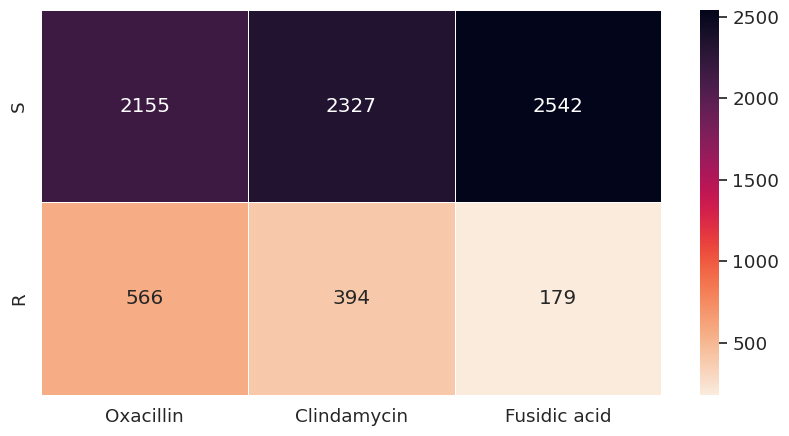

In [4]:
sns.set(rc={'figure.figsize':(10, 5)})
sns.set(font_scale=1.2)
sns.heatmap(r_bac[r_labels].apply(pd.Series.value_counts), annot=True, fmt="d", linewidth=.5, cmap="rocket_r")

## **Distribution of values for each block of Da**

One possible way to check if there's any observable visual patterns in the distribution of the data is through the visualization of the mean and the confidence interval of each Da block.

For this, certain tweaks to the dataset are required: the Da blocks must be values instead of columns.

In [5]:
meltdata = r_bac.melt(r_labels, var_name='Da', value_name='Value')
meltdata["Da"] = meltdata["Da"].astype(str).astype(int)
meltdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 816300 entries, 0 to 816299
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Oxacillin     816300 non-null  object 
 1   Clindamycin   816300 non-null  object 
 2   Fusidic acid  816300 non-null  object 
 3   Da            816300 non-null  int64  
 4   Value         816300 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 31.1+ MB


In [6]:
linewidth = 4
label_size = 28
axis_tick_size = 28
legend_size = '32'
y_label_format = '{:,.3f}'
palette = sns.color_palette("tab10")[:2**len(r_labels)]
sns.set(font_scale=1)

With this transformation, the next step is to make a lineplot for each antibiotic, differentiating the susceptible and resistant rows through its legend; blue for susceptible ones, orange for resistant ones.

In [7]:
def one_antibiotic_lineplot(i):
    fig, axes = plt.subplots(1, 1, figsize=(30, 20))
    
    sns.set(font_scale = 2)
    line = sns.lineplot(ax=axes, data=meltdata, x="Da", y="Value", hue=r_labels[i], 
                            palette={"S": "C0", "R": "C1"}, linewidth=linewidth)
    line.set(xticks=np.arange(2000, 8001, 400))
    line.set_xlabel("Da", fontsize=label_size)
    line.set_ylabel("Value", fontsize=label_size)

    line.set_xticklabels(axes.get_xticks(), size=axis_tick_size)
    ticks_loc = axes.get_yticks()
    axes.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    axes.set_yticklabels([y_label_format.format(x) for x in ticks_loc], size=axis_tick_size)

    plt.setp(line.get_legend().get_texts(), fontsize=legend_size) 
    plt.setp(line.get_legend().get_title(), fontsize=legend_size) 
    axes.margins(x=0.005)


**Oxacillin**

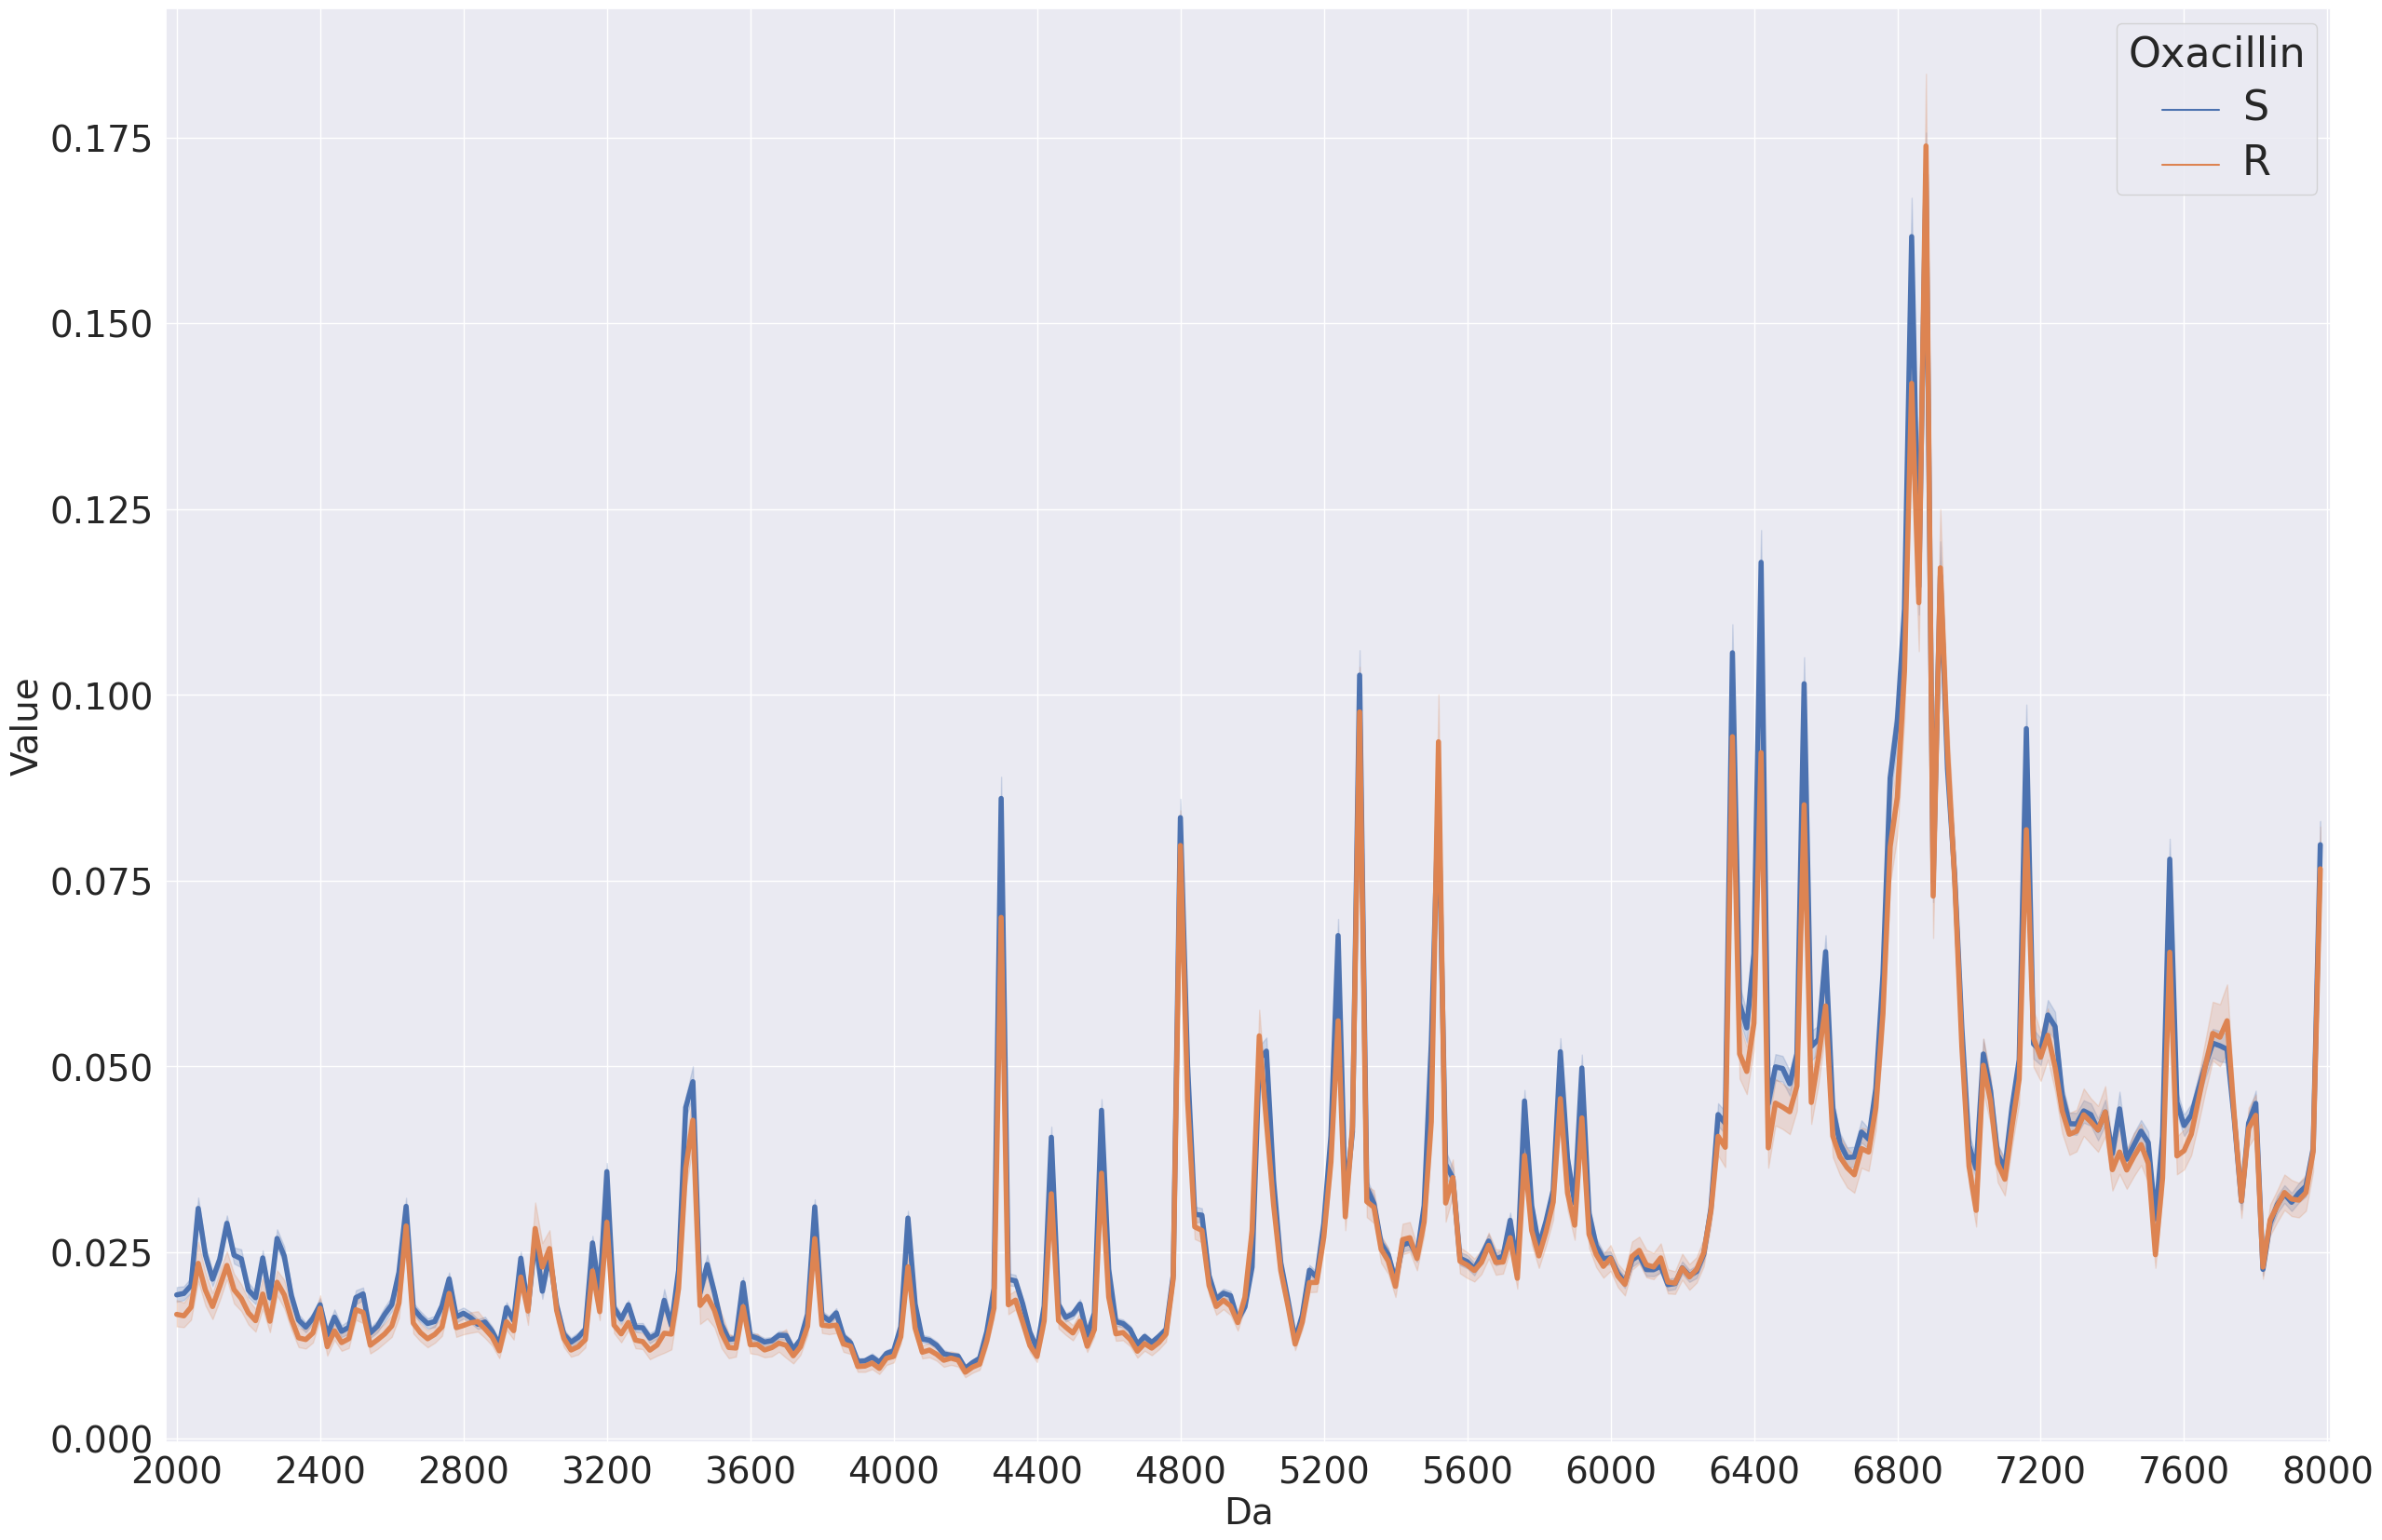

In [8]:
one_antibiotic_lineplot(0)

**Clindamycin**

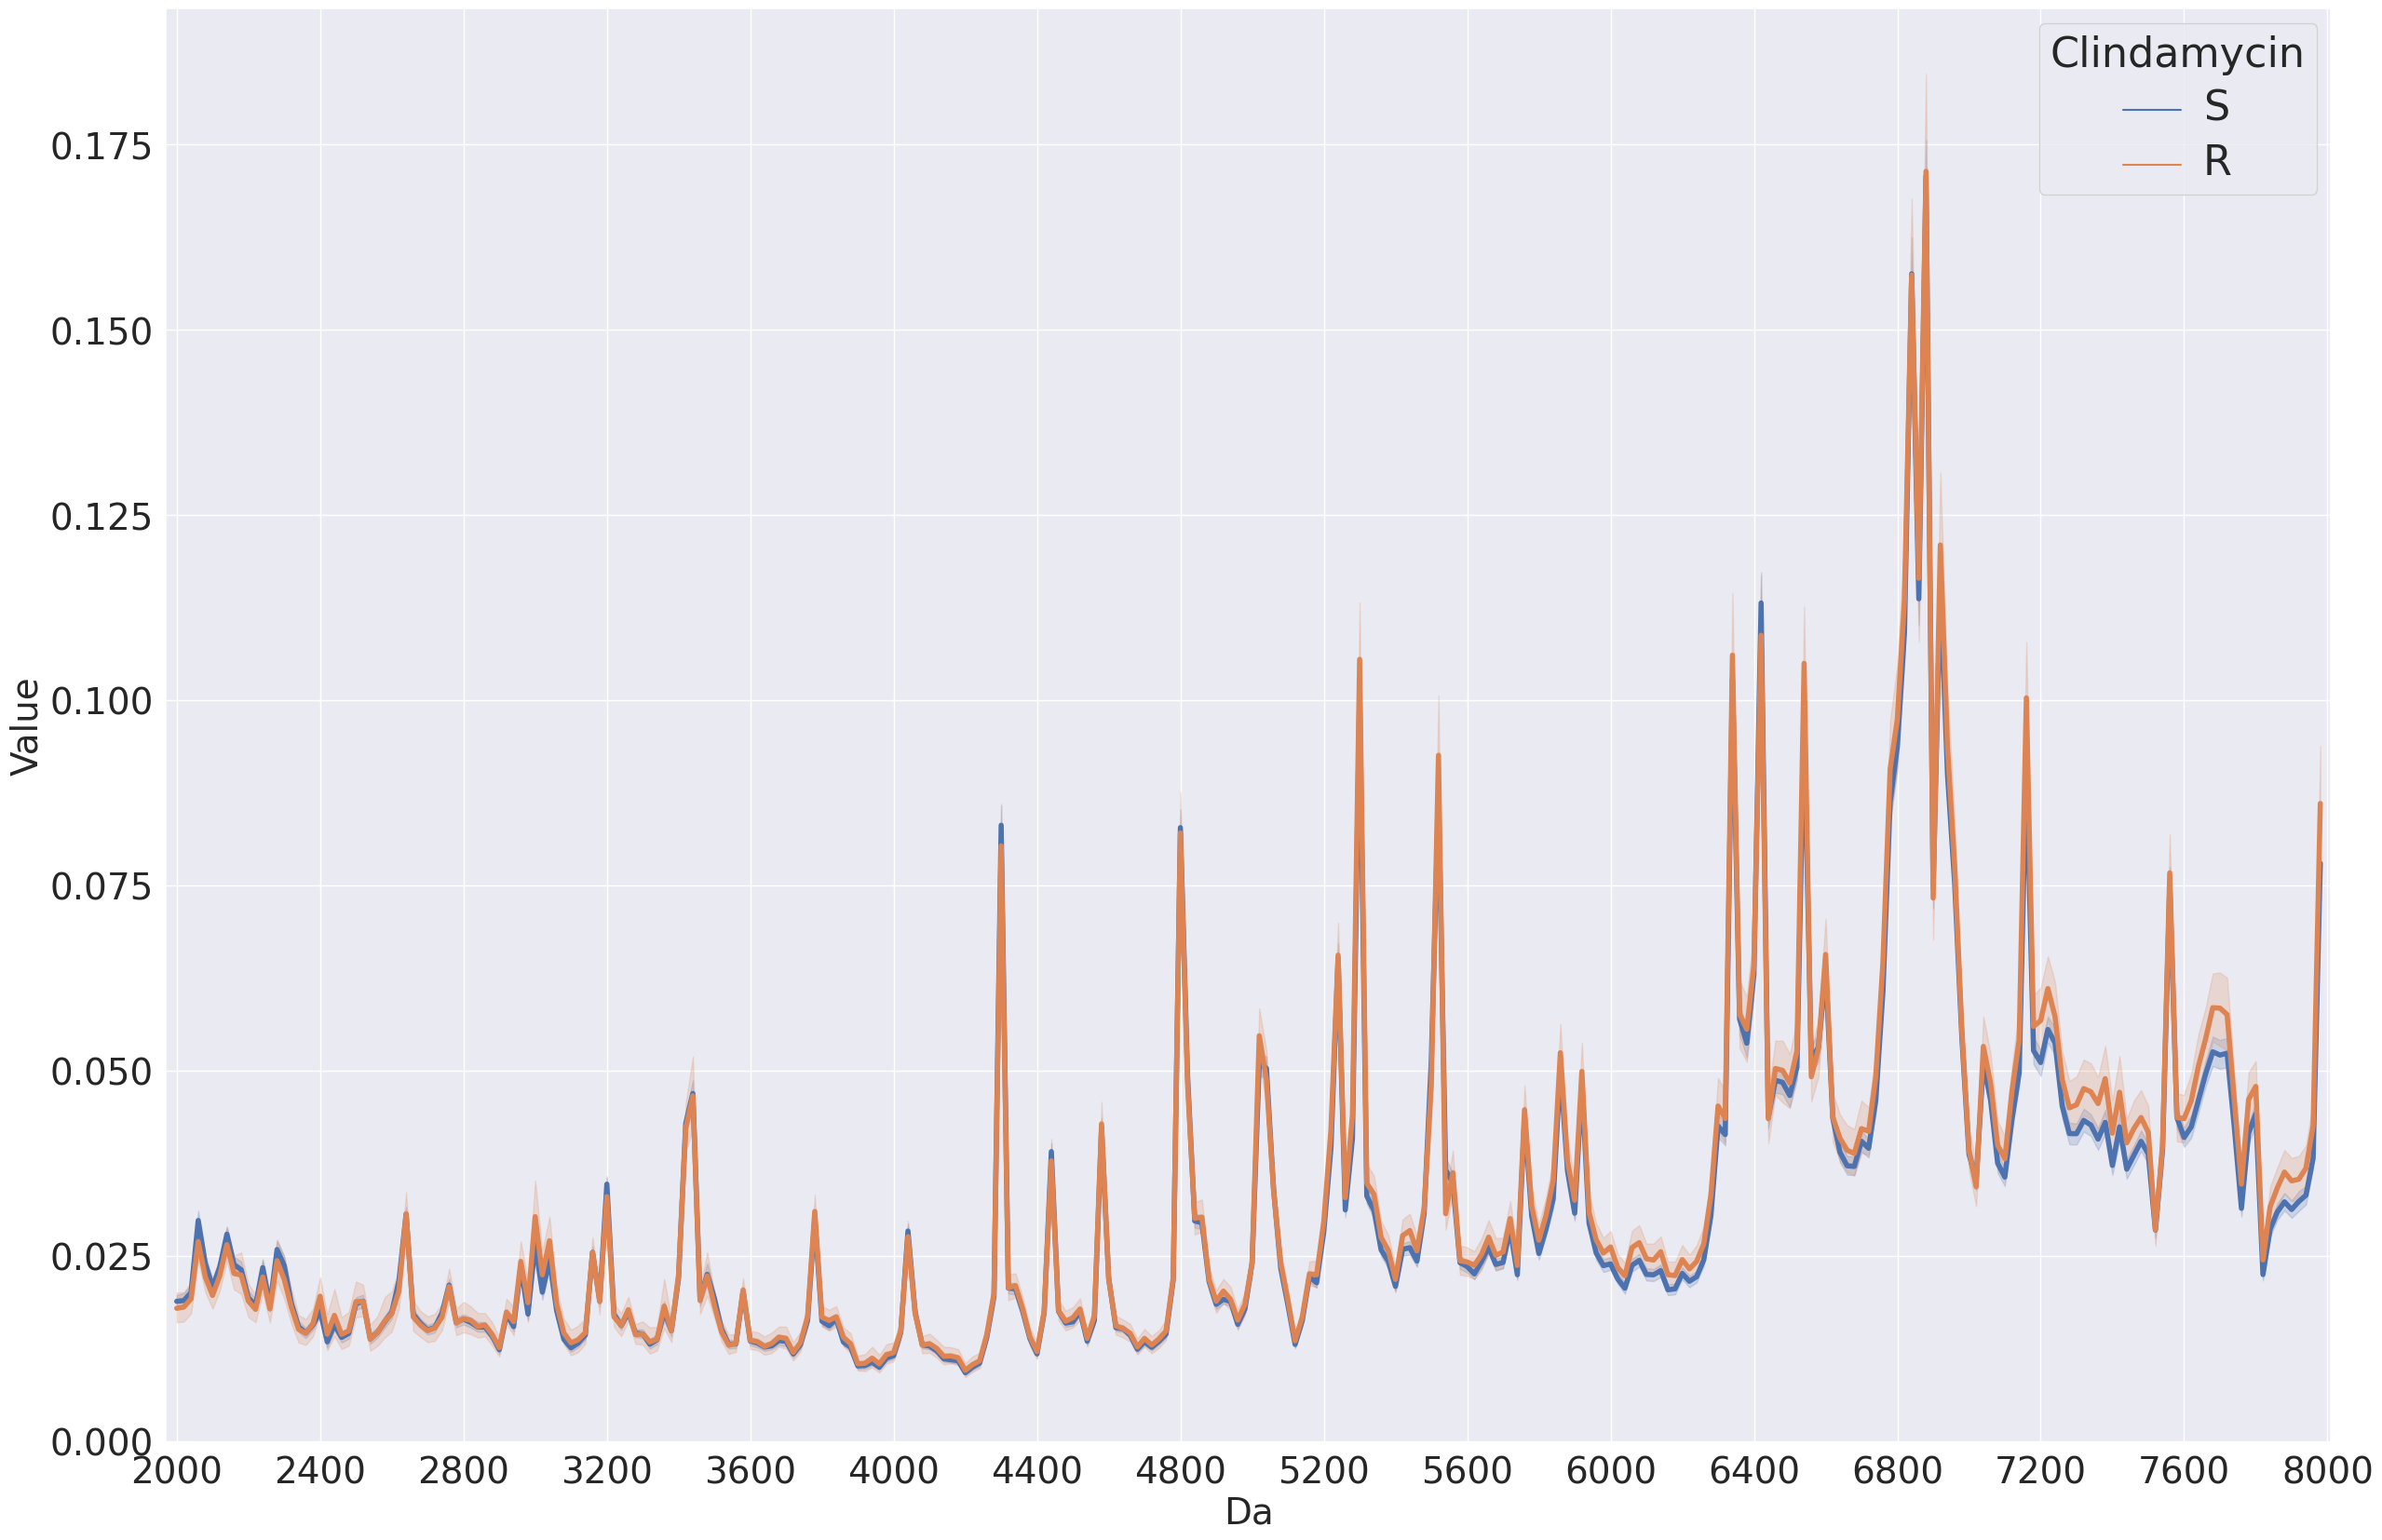

In [9]:
one_antibiotic_lineplot(1)

**Fusidic Acid**

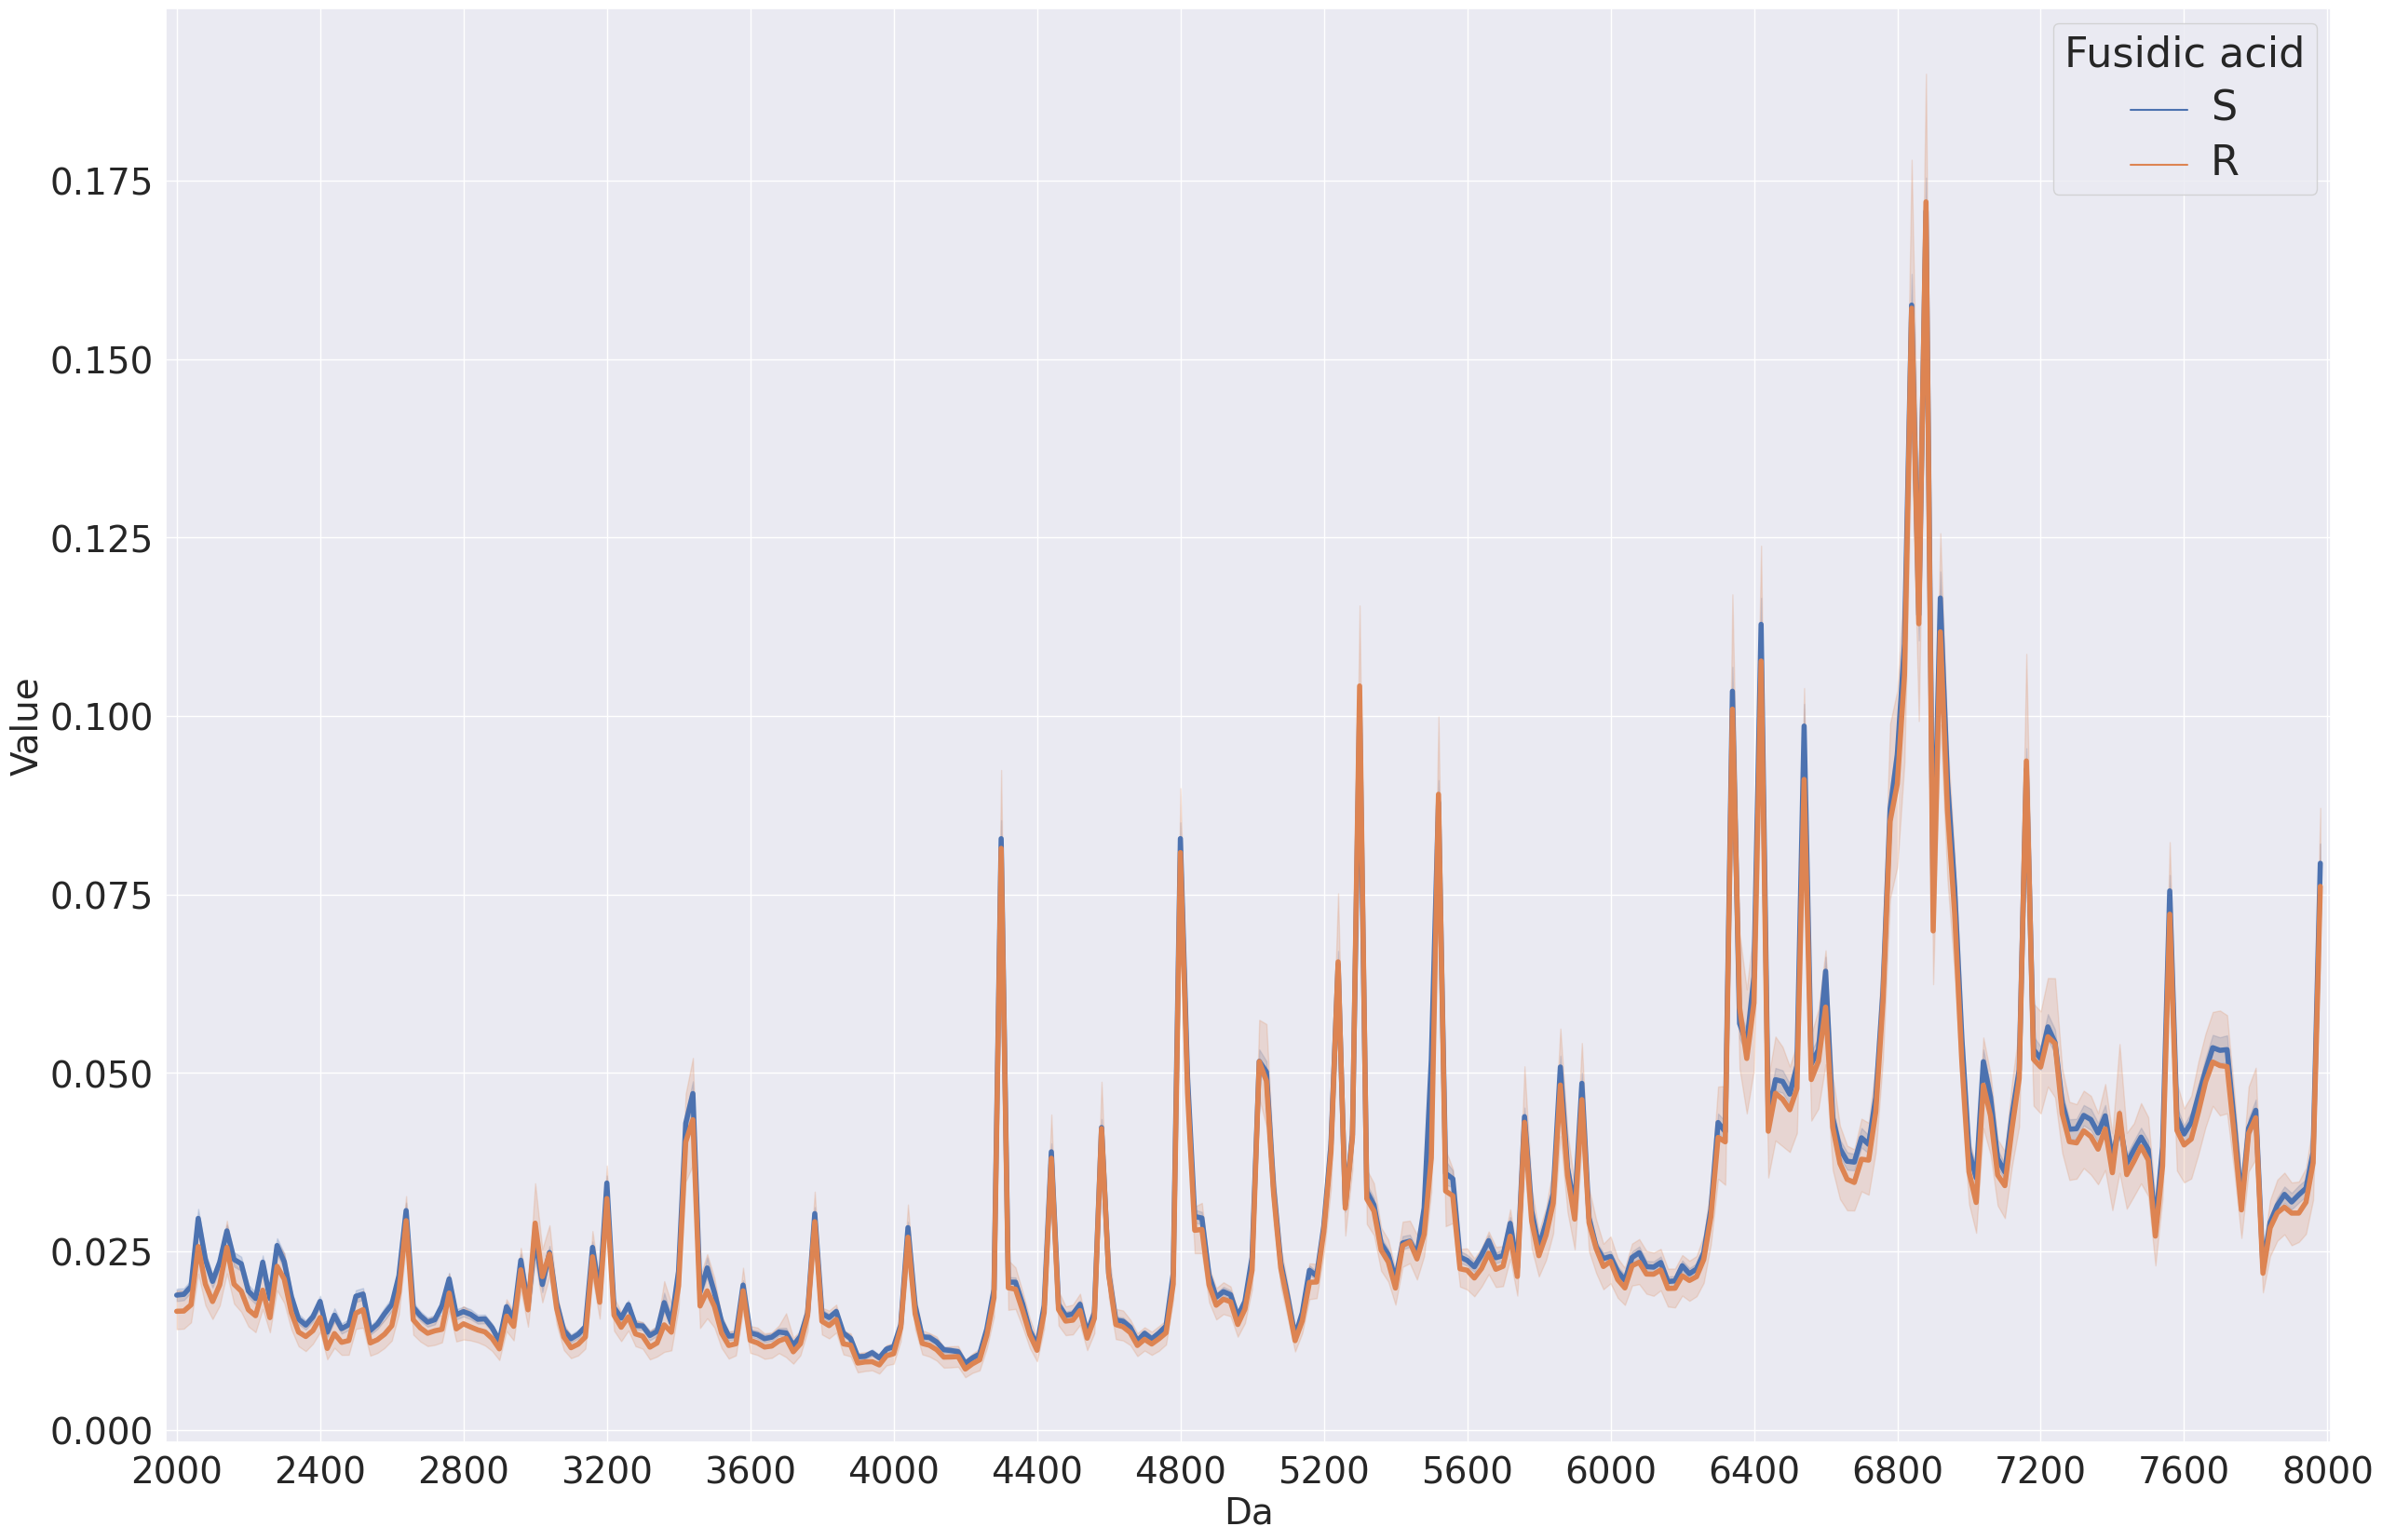

In [10]:
one_antibiotic_lineplot(2)

Having removed the outliers, the confidence intervals shown in the previous line plots have been greatly reduced in most regions. 

The classes remain close to one another.

---

Now, we repeat the same experiment but, instead of looking at each antibiotic separately, we join them together as if it were a multi-class problem.

For this, we need to create a new column with the joint labels to our previous transformed data.


In [11]:
meltdata_lps = meltdata
meltdata_lps["Class"] = meltdata[r_labels].agg(''.join, axis=1)
meltdata_lps["Class"] = meltdata_lps["Class"].astype(str)
meltdata_lps

,Oxacillin,Clindamycin,Fusidic acid,Da,Value,Class
0,S,S,S,2000,0.045520,SSS
1,S,S,S,2000,0.017259,SSS
2,S,S,S,2000,0.004456,SSS
3,S,S,S,2000,0.087679,SSS
4,S,S,S,2000,0.002474,SSS
...,...,...,...,...,...,...
816295,S,S,S,7980,0.071416,SSS
816296,S,S,S,7980,0.119627,SSS
816297,S,S,S,7980,0.006031,SSS
816298,R,S,S,7980,0.105793,RSS


Now, same as we did previously, we construct a lineplot with the transformed data, with the legend representing each class (combination of susceptibility/resistence to the antibiotics).

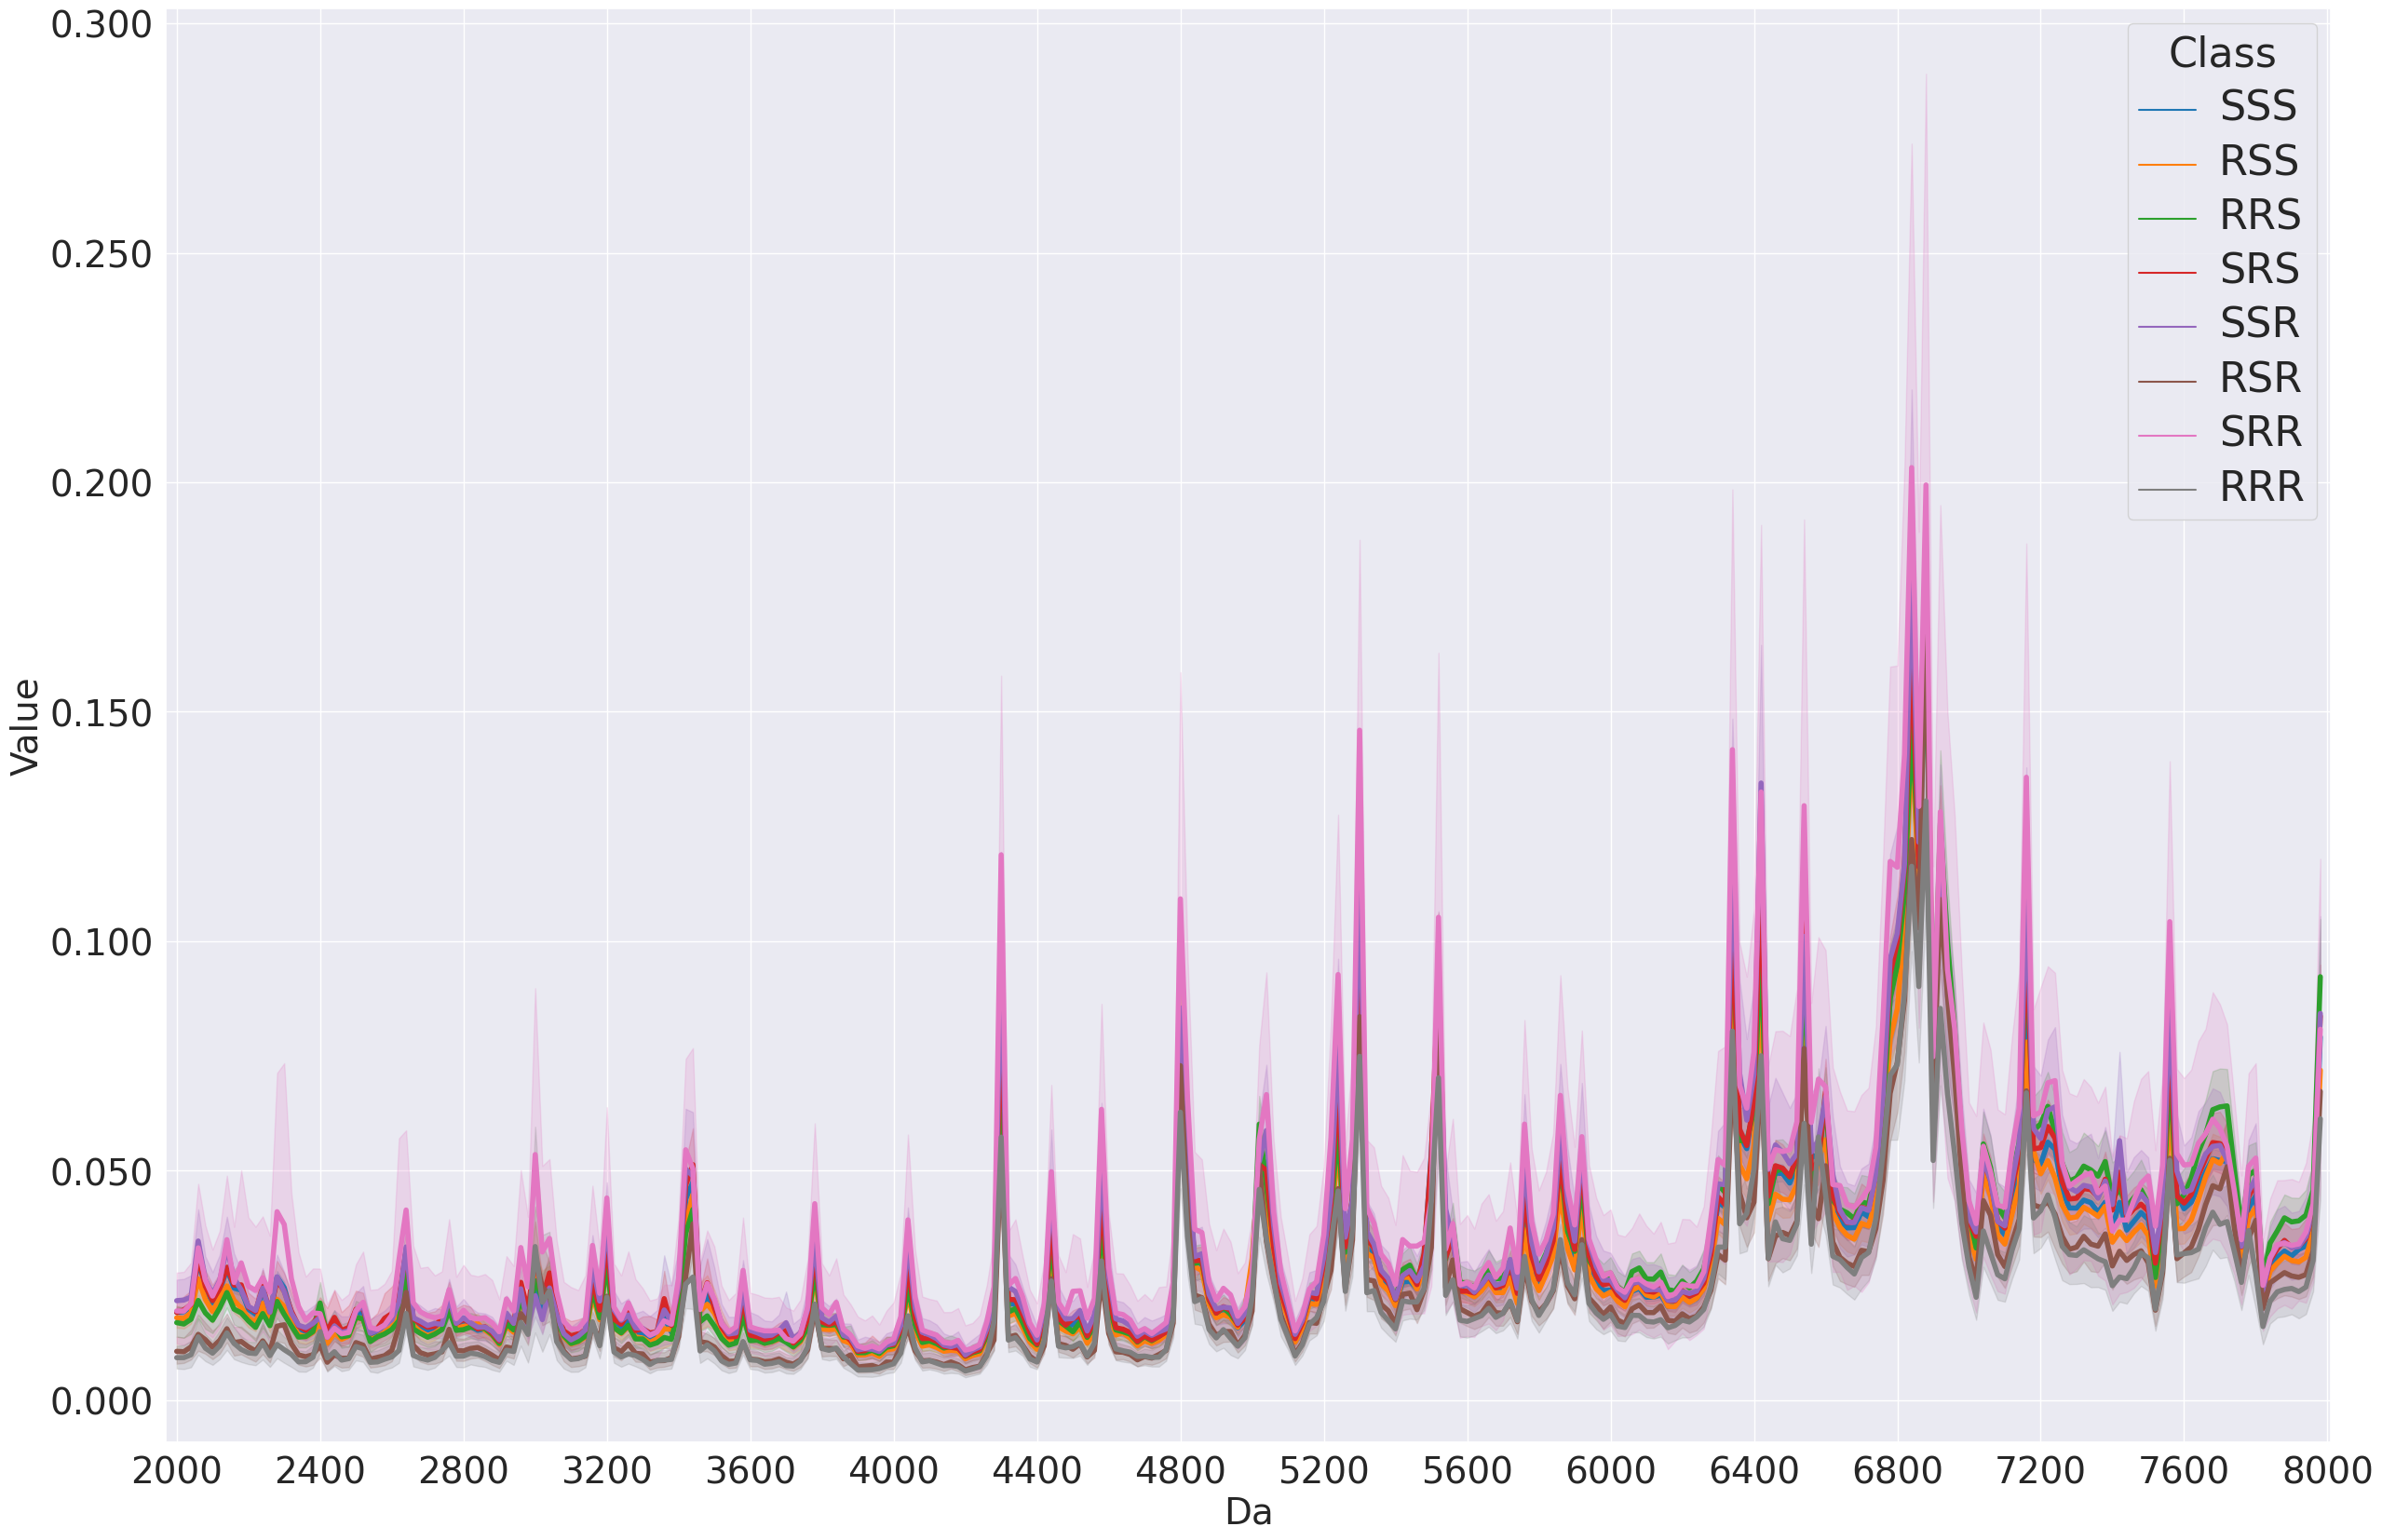

In [12]:
fig, axes = plt.subplots(figsize=(30, 20))

line = sns.lineplot(data=meltdata_lps, x="Da", y="Value", hue="Class", linewidth=linewidth, palette=palette)
line.set(xticks=np.arange(2000, 8001, 400))
line.set_xlabel("Da", fontsize=label_size)
line.set_ylabel("Value", fontsize=label_size)

line.set_xticklabels(axes.get_xticks(), size=axis_tick_size)
ticks_loc = axes.get_yticks()
axes.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
axes.set_yticklabels([y_label_format.format(x) for x in ticks_loc], size=axis_tick_size)

plt.setp(line.get_legend().get_texts(), fontsize=legend_size) 
plt.setp(line.get_legend().get_title(), fontsize=legend_size) 

axes.margins(x=0.005)

Compared to before, now the RRR instances are much closer to all other classes, being hard to even tell apart in the graph, meaning that the RRR instances don't behave quite as differently as the original plot would made it seem.

## **Scatter Plots**

One of the most convenient ways to observe how the rows group together is through the use of scatter plots. However, the dataset contains 300 columns and visualizing on a Scatter Plot would prove difficult.

To achieve this, the data has to be transformed and its dimensions reduced.

First, we separate the labels from the features and condense the multiple labels into a single one by combining the columns together.

In [13]:
y_lps = pd.DataFrame()
y_lps["Class"] = r_bac[r_labels].agg(''.join, axis=1)
y_lps["Class"] = y_lps["Class"].astype(str)
y_lps

,Class
0,SSS
1,SSS
2,SSS
3,SSS
4,SSS
...,...
2716,SSS
2717,SSS
2718,SSS
2719,RSS


We convert the produced classes into numbers, so that models can handle them properly.
To do this, we use a Label Encoder.

In [14]:
lc = LabelEncoder()
lc.fit(y_lps.values.ravel())
y_lps = lc.transform(y_lps.values.ravel())
y_lps

array([7, 7, 7, ..., 7, 3, 3])

When required, we can check which class corresponds to each number by doing an inverse transform.

In [15]:
for i in range(2**len(r_labels)):
    print(str(i)+":", lc.inverse_transform([i]))

0: ['RRR']
1: ['RRS']
2: ['RSR']
3: ['RSS']
4: ['SRR']
5: ['SRS']
6: ['SSR']
7: ['SSS']


Now, we separate the features from the labels.

In [16]:
X = r_bac.iloc[:, :-len(r_labels)]
X

,2000,2020,2040,2060,2080,2100,2120,2140,2160,2180,...,7800,7820,7840,7860,7880,7900,7920,7940,7960,7980
0,0.045520,0.049164,0.053732,0.103799,0.070313,0.054133,0.066685,0.062658,0.065464,0.052958,...,0.015380,0.008802,0.011562,0.013030,0.014085,0.013747,0.013751,0.017801,0.019805,0.016569
1,0.017259,0.017404,0.018424,0.021564,0.021515,0.017156,0.018783,0.024013,0.021183,0.020315,...,0.058418,0.023025,0.025611,0.030503,0.031433,0.029932,0.028772,0.031634,0.031223,0.070219
2,0.004456,0.004988,0.005678,0.012892,0.008272,0.005309,0.007186,0.007899,0.007782,0.006989,...,0.035325,0.018731,0.025138,0.027980,0.030444,0.027396,0.030451,0.031686,0.039274,0.092733
3,0.087679,0.079606,0.080376,0.099183,0.088755,0.075990,0.080818,0.072312,0.075789,0.078015,...,0.039326,0.020837,0.023787,0.025271,0.025498,0.024893,0.024923,0.023928,0.028272,0.039272
4,0.002474,0.002419,0.002358,0.004563,0.004108,0.002871,0.002792,0.003716,0.003722,0.003371,...,0.027848,0.011605,0.011982,0.014546,0.014997,0.013014,0.013827,0.014606,0.018225,0.042739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2716,0.014471,0.014261,0.014812,0.024280,0.017555,0.014864,0.016927,0.022291,0.015765,0.013412,...,0.028849,0.016822,0.026557,0.026568,0.028946,0.027226,0.029400,0.031105,0.035675,0.071416
2717,0.051320,0.043270,0.042688,0.047761,0.044180,0.041507,0.045532,0.052566,0.043973,0.044534,...,0.119703,0.050316,0.050151,0.051332,0.052892,0.051383,0.044976,0.044261,0.055749,0.119627
2718,0.027629,0.026645,0.029737,0.057110,0.039290,0.034540,0.042135,0.042975,0.036420,0.030301,...,0.006143,0.003367,0.002995,0.003987,0.003996,0.003625,0.003666,0.002803,0.004356,0.006031
2719,0.005350,0.006803,0.006776,0.017303,0.009075,0.006464,0.009227,0.012376,0.010396,0.006687,...,0.046430,0.020137,0.027494,0.027414,0.031705,0.027158,0.026610,0.032736,0.038164,0.105793


### **PCA**
The first method used to reduce the dimensions of the data is PCA (Principal Component Analysis).

Through this, we extract the top 2 components with the highest variance. This way, while we lose some information, we can create a 2D scatter plot.

In [17]:
pca = PCA(n_components=2, random_state=0)
pca.fit(X)
X_pca = pca.transform(X)

Having fit the PCA, we obtain the 2 components with the highest variance.

In [18]:
X_pca

array([[-0.12681145,  0.114953  ],
       [-0.03123965, -0.01029236],
       [-0.09038274, -0.1023984 ],
       ...,
       [-0.36673062,  0.0882478 ],
       [ 0.13423234, -0.23976841],
       [-0.10547234, -0.01248683]])

In [19]:
print("Variance of each column:", pca.explained_variance_ratio_)
print("Total:", pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1])

Variance of each column: [0.70158255 0.07366846]
Total: 0.775251016241743


It can be observed that these columns contain 77% fo the variance of the data.

These two columns are used to make the PCA scatter plot.

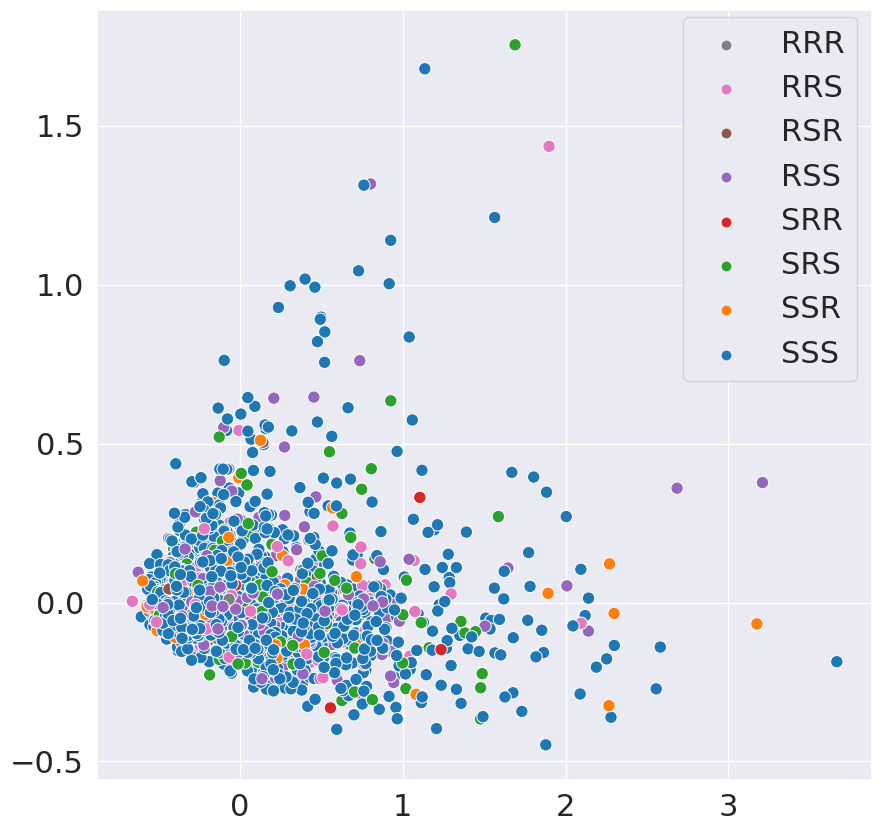

In [35]:
fig, axes = plt.subplots(figsize=(10, 10))

s = sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_lps, s=80, palette=palette[::-1])

plt.setp(s.get_legend().get_texts(), fontsize="16") 
plt.legend(loc='upper right', bbox_to_anchor=(1, 1.01))

for t, l in zip(s.legend_.texts, lc.inverse_transform(range(2**len(r_labels)))):
    t.set_text(l)

From the scatter plot, we can observe something that could possibly be a problem: instances are all grouped close to each other, regardless of their class.

## **T-SNE**

T-SNE is another, different, way of reducing the dimensions of the data.

To simplify its application, we define a pre-made function which handles its execution and visualization at different perplexities.

In [56]:
def perform_tsne(X_data, y_data, labels, perplexities, colors=palette, n_iter=1000, reversed_labels=False):

    for index,perplexity in enumerate(perplexities):
        print("\nPerforming tsne with perplexity {} and with {} iterations at max".format(perplexity, n_iter))
        X_reduced = TSNE(verbose=0, perplexity=perplexity, n_jobs=-1, learning_rate=200.0, init="random", random_state=0).fit_transform(X_data)
        df = pd.DataFrame({"x":X_reduced[:,0], "y":X_reduced[:,1] , "label":y_data})

        fig, axes = plt.subplots(figsize=(10, 10))

        s = sns.scatterplot(data=df, x="x", y="y", hue=y_lps, s=80, palette=palette[::-1])
        s.set(xlabel=None)
        s.set(ylabel=None)

        plt.setp(s.get_legend().get_texts(), fontsize="16") 
        plt.legend(loc='upper right', bbox_to_anchor=(1, 1.01))

        for t, l in zip(s.legend_.texts, lc.inverse_transform(range(2**len(r_labels)))):
            t.set_text(l)
        plt.show()
        print("Done")

We apply the T-SNE on the standardized features and multi-class labels, at five different perplexities: 2, 5, 10, 20 and 50.

Se ejecuta el T-SNE para los datos trabajados y las perplejidades indicadas.


Performing tsne with perplexity 20 and with 1000 iterations at max


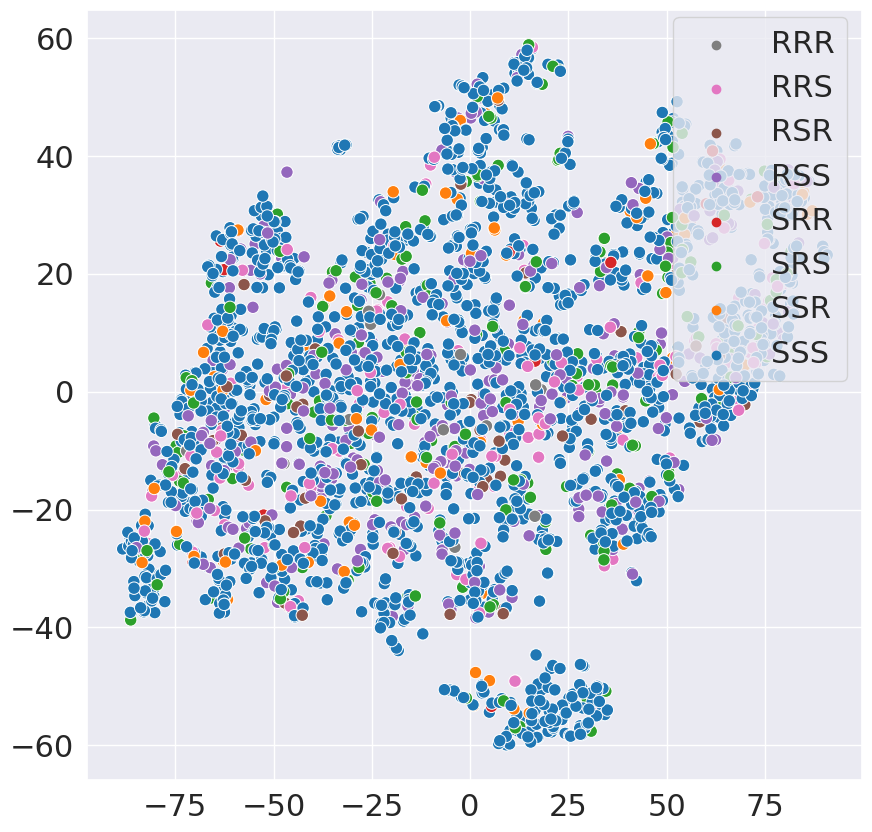

Done


In [57]:
perform_tsne(X_data=X, y_data=y_lps, labels=lc.inverse_transform(range(2**len(r_labels))), perplexities=[20])

Yet another challenge rises: all classes are found broadly dispersed across the plot, without forming any noticeable patterns.

---

From this exploration, it can be concluded that this is a problem of high complexity, that will require similarly complex tools.